In [1]:
import pandas as pd
import math
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from bikescience.history import load_history
from bikescience.usage_metric import compute_usage_variation
import bikescience.input_data as input
from bikescience.filter_select import holiday_dates

Total slots from history

In [13]:
history = pd.read_csv('data/output/clean_history.csv', parse_dates=['timestamp'])
history['per_day'] = history['timestamp'].dt.to_period('d').dt.to_timestamp()
total_slots = history.groupby(['id', 'name', 'per_day'], as_index=False).agg({'total_slots': 'max'})

May I use the max? Inspecting the variation:

In [14]:
history.groupby(['id', 'name'], as_index=False).agg({'total_slots': 'std'}) \
    .sort_values('total_slots', ascending=False).head(5)

id                             name  \
45  67e2474c12c4e76e640724b6b2df9f47          12 - Largo de Batata II   
79  acb732cd5739a3bf5962c3fe35f41e1f              1 - Largo da Batata   
4   060b7bd093ab6900379d311100e6c0d7               201 - Metro Sumaré   
52  6f0ce1a3e4a933999494f860ab32ee62           23 - CPTM Vila Olímpia   
29  3fbf5c644236a6ed5162e9977843a8cf  241 - CPTM Cidade Universitária   

    total_slots  
45    19.927652  
79    18.113590  
4      7.404665  
52     7.082310  
29     6.898699

Daily total increase and decreases:

In [15]:
usage_variation = compute_usage_variation(history, 'per_day')
usage_variation.head(5)

id                           name    per_day  \
0  003c832d084651a62af515b0a330eb55  239 - Avenida Antônio Batuira 2018-05-26   
1  003c832d084651a62af515b0a330eb55  239 - Avenida Antônio Batuira 2018-05-27   
2  003c832d084651a62af515b0a330eb55  239 - Avenida Antônio Batuira 2018-05-28   
3  003c832d084651a62af515b0a330eb55  239 - Avenida Antônio Batuira 2018-05-29   
4  003c832d084651a62af515b0a330eb55  239 - Avenida Antônio Batuira 2018-05-30   

   free_bikes_increase  free_bikes_decrease  
0                    1                    5  
1                    1                    8  
2                    1                    7  
3                   10                   14  
4                   10                   21

Features:

In [16]:
socioeconomic = input.load_socioeconomic()
geographic = input.load_stations_hexagons()
weather = input.load_per_hour_weather()
unbalance = input.load_unbalance_index()
accessibility = input.load_accessibility(geographic)

Weather daily summary:

In [17]:
def weather_daily_agg(group):
    names = {
        'mean_temperature': group['instant_temperature'].mean(), 
        'max_temperature': group['max_temperature'].max(), 
        'min_temperature': group['min_temperature'].min(), 
        'mean_humidity': group['instant_humidity'].mean(), 
        'max_humidity': group['max_humidity'].max(),
        'min_humidity': group['min_humidity'].min(), 
        'mean_moisture': group['instant_dew'].mean(), 
        'max_moisture': group['max_dew'].max(), 
        'min_moisture': group['min_dew'].min(),
        'mean_atm_pressure': group['atm_pressure'].mean(), 
        'max_atm_pressure': group['max_atm_pressure'].max(), 
        'min_atm_pressure': group['min_atm_pressure'].min(), 
        'min_wind_vel': group['wind_velocity'].mean(),
        'max_wind_vel': group['wind_velocity'].max(),
        'min_wind_vel': group['wind_velocity'].min(),
        'wind_gusts': group[' wind_gust'].sum(), 
        'mean_radiation': group['radiation'].mean(), 
        'max_radiation': group['radiation'].max(), 
        'min_radiation': group['radiation'].min(),
        'mean_precipitation': group['precipitation'].mean(),
        'max_precipitation': group['precipitation'].max(),
        'min_precipitation': group['precipitation'].mean(),
    }
    return pd.Series(names)


weather['per_day'] = weather['per_hour'].dt.to_period('d').dt.to_timestamp()
daily_weather = weather.groupby(['per_day']).apply(weather_daily_agg)
daily_weather.head(5)

max_atm_pressure  max_humidity  max_moisture  max_precipitation  \
per_day                                                                       
2018-05-26             934.8          95.0          15.7                0.0   
2018-05-27             936.4          97.0          15.6                0.0   
2018-05-28             936.9          96.0          14.5                0.0   
2018-05-29             936.9          94.0          15.2                0.0   
2018-05-30             935.2          97.0          14.9                0.2   

            max_radiation  max_temperature  max_wind_vel  mean_atm_pressure  \
per_day                                                                       
2018-05-26         2371.0             21.7         166.0         933.141667   
2018-05-27         2442.0             21.8         202.0         934.416667   
2018-05-28         2436.0             22.4         146.0         935.150000   
2018-05-29         2473.0             22.6         152.0         934.737500   
2018-05-30         2497.0             22.9         360.0         933.225000   

            mean_humidity  mean_moisture     ...      mean_radiation  \
per_day                                      ...                       
2018-05-26      84.500000      14.233333     ...          562.455833   
2018-05-27      84.208333      13.820833     ...          583.955167   
2018-05-28      82.083333      12.841667     ...          652.250167   
2018-05-29      77.375000      12.283333     ...          655.033750   
2018-05-30      74.208333      11.837500     ...          650.716250   

            mean_temperature  min_atm_pressure  min_humidity  min_moisture  \
per_day                                                                      
2018-05-26         16.991667             931.6          59.0          12.8   
2018-05-27         16.691667             933.1          55.0          12.1   
2018-05-28         16.158333             933.9          45.0           9.4   
2018-05-29         16.816667             933.1          36.0           6.3   
2018-05-30         17.295833             930.6          30.0           3.6   

            min_precipitation  min_radiation  min_temperature  min_wind_vel  \
per_day                                                                       
2018-05-26           0.000000           -3.6             14.4          55.0   
2018-05-27           0.000000           -3.6             13.6          41.0   
2018-05-28           0.000000           -3.6             12.2          67.0   
2018-05-29           0.000000           -3.6             13.4           8.0   
2018-05-30           0.008333           -3.6             13.7           5.0   

            wind_gusts  
per_day                 
2018-05-26       116.8  
2018-05-27       109.3  
2018-05-28       115.8  
2018-05-29       120.8  
2018-05-30       101.0  

[5 rows x 21 columns]

Joining everything togegher

In [18]:
geographic.columns = ['id', 'name', 'hex_id']
samples = total_slots \
    .merge(usage_variation, on=['id', 'name', 'per_day']) \
    .merge(daily_weather, on='per_day') \
    .merge(geographic, on=['id', 'name']) \
    .merge(socioeconomic, on='hex_id') \
    .merge(accessibility, left_on=['id', 'name'], right_on=['station_id', 'name'], how='left')
samples['work_day'] = ~samples['per_day'].dt.dayofweek.isin([5, 6]) & ~samples['per_day'].dt.date.isin(holiday_dates)
samples['in_accessibility'].fillna(0, inplace=True)
samples['out_accessibility'].fillna(0, inplace=True)
resampled = samples
print(len(samples), 'samples')
print(samples.columns.tolist())
samples.head(5)

9754 samples
['id', 'name', 'per_day', 'total_slots', 'free_bikes_increase', 'free_bikes_decrease', 'max_atm_pressure', 'max_humidity', 'max_moisture', 'max_precipitation', 'max_radiation', 'max_temperature', 'max_wind_vel', 'mean_atm_pressure', 'mean_humidity', 'mean_moisture', 'mean_precipitation', 'mean_radiation', 'mean_temperature', 'min_atm_pressure', 'min_humidity', 'min_moisture', 'min_precipitation', 'min_radiation', 'min_temperature', 'min_wind_vel', 'wind_gusts', 'hex_id', 'total_loading', 'total_unloading', 'stops_len', 'trips_len', 'job_qty', 'population', 'education_qty', 'health_qty', '0_2_salaries', '2_3_salaries', '3_5_salaries', '5_10_salaries', 'above_10_salaries', 'station_id', 'in_accessibility', 'out_accessibility', 'work_day']


id                           name    per_day  \
0  003c832d084651a62af515b0a330eb55  239 - Avenida Antônio Batuira 2018-05-26   
1  003c832d084651a62af515b0a330eb55  239 - Avenida Antônio Batuira 2018-05-27   
2  003c832d084651a62af515b0a330eb55  239 - Avenida Antônio Batuira 2018-05-28   
3  003c832d084651a62af515b0a330eb55  239 - Avenida Antônio Batuira 2018-05-29   
4  003c832d084651a62af515b0a330eb55  239 - Avenida Antônio Batuira 2018-05-30   

   total_slots  free_bikes_increase  free_bikes_decrease  max_atm_pressure  \
0           15                    1                    5             934.8   
1           15                    1                    8             936.4   
2           15                    1                    7             936.9   
3           15                   10                   14             936.9   
4           15                   10                   21             935.2   

   max_humidity  max_moisture  max_precipitation    ...     health_qty  \
0          95.0          15.7                0.0    ...              0   
1          97.0          15.6                0.0    ...              0   
2          96.0          14.5                0.0    ...              0   
3          94.0          15.2                0.0    ...              0   
4          97.0          14.9                0.2    ...              0   

   0_2_salaries  2_3_salaries  3_5_salaries  5_10_salaries  above_10_salaries  \
0             0             0             0              0                  0   
1             0             0             0              0                  0   
2             0             0             0              0                  0   
3             0             0             0              0                  0   
4             0             0             0              0                  0   

                         station_id  in_accessibility  out_accessibility  \
0  003c832d084651a62af515b0a330eb55          54.59046          62.470427   
1  003c832d084651a62af515b0a330eb55          54.59046          62.470427   
2  003c832d084651a62af515b0a330eb55          54.59046          62.470427   
3  003c832d084651a62af515b0a330eb55          54.59046          62.470427   
4  003c832d084651a62af515b0a330eb55          54.59046          62.470427   

   work_day  
0     False  
1     False  
2      True  
3      True  
4      True  

[5 rows x 45 columns]

Sample values distribution:

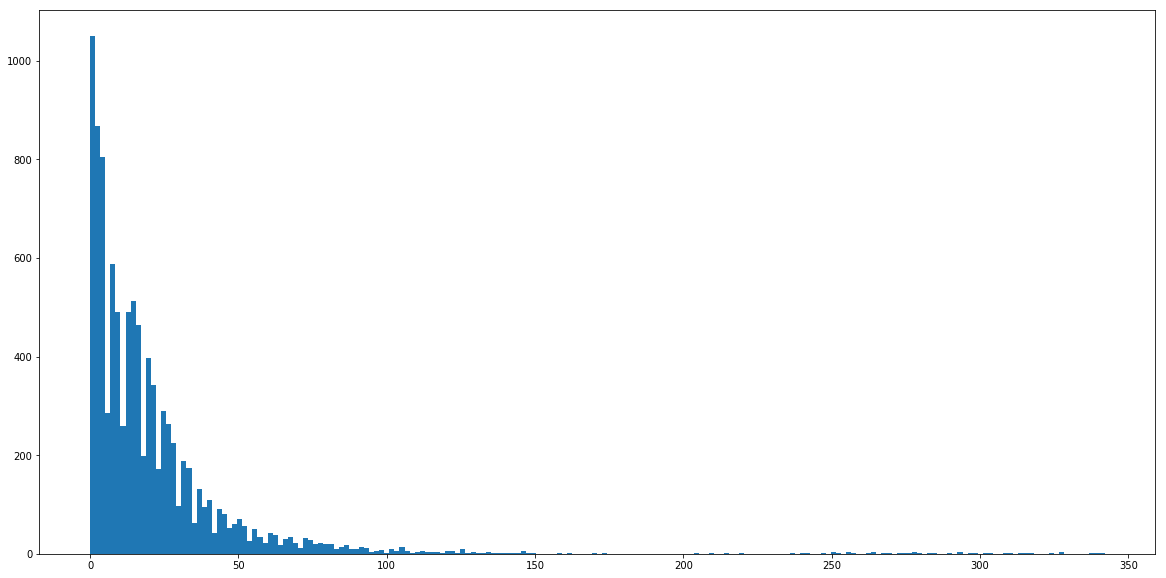

In [19]:
plt.figure(figsize=(20, 10))
plt.hist(samples['free_bikes_increase'], bins=200)
plt.show()

Resampling:

* *above 50:* everything

In [17]:
filtered = samples[samples['free_bikes_increase'] > 50]
n50 = len(filtered)
print(n50, 'samples with more than 50 bike arrivals per day.')
samples_index = filtered.index

839 samples with more than 50 bike arrivals per day.


* *the others:* take proportionally

In [18]:
filtered = samples[samples['free_bikes_increase'] <= 50]
counts = filtered['free_bikes_increase'].value_counts()
n_less = len(filtered)
assert n_less == counts.sum()
assert len(counts) == 51  # includes the zero value
print(len(counts), 'values are present, min:', counts.index.min(), 'max:', counts.index.max())
print(n_less, 'samples up to 50 bike arrivals per day.')

take = math.ceil(n50 / 51)
print(take, 'samples will be takem for each bike arrivals count.')
assert take <= counts.min()

for val in counts.index:
    filtered = samples[samples['free_bikes_increase'] == val].sample(n=take)
    samples_index = samples_index.append(filtered.index)
    
resampled = samples.loc[samples_index]
print(len(resampled), 'sample values selected')
resampled.head(5)

51 values are present, min: 0 max: 50
8915 samples up to 50 bike arrivals per day.
17 samples will be takem for each bike arrivals count.
1706 sample values selected


id                  name    per_day  \
1951  33142afea930cc3f6a84bebc9371b1db    122 - Rua Baluarte 2018-08-14   
2385  3992c0ba37ef226cfc767b1b38783492  14 - Casa Brasileira 2018-05-30   
2388  3992c0ba37ef226cfc767b1b38783492  14 - Casa Brasileira 2018-06-02   
2394  3992c0ba37ef226cfc767b1b38783492  14 - Casa Brasileira 2018-06-08   
2404  3992c0ba37ef226cfc767b1b38783492  14 - Casa Brasileira 2018-06-18   

      total_slots  free_bikes_increase  free_bikes_decrease  max_atm_pressure  \
1951           15                   51                   81             931.2   
2385           17                   64                   75             935.2   
2388           17                   51                   43             930.4   
2394           17                   55                   72             932.5   
2404           17                   53                   69             938.5   

      max_humidity  max_moisture  max_precipitation    ...     health_qty  \
1951          97.0          15.0                0.0    ...              0   
2385          97.0          14.9                0.2    ...              0   
2388          77.0          15.1                0.0    ...              0   
2394          96.0          16.7                1.6    ...              0   
2404          98.0          15.6                0.2    ...              0   

      0_2_salaries  2_3_salaries  3_5_salaries  5_10_salaries  \
1951             0             0             0              0   
2385             0             0             0              0   
2388             0             0             0              0   
2394             0             0             0              0   
2404             0             0             0              0   

      above_10_salaries                        station_id  in_accessibility  \
1951                  0  33142afea930cc3f6a84bebc9371b1db         52.001107   
2385                  0  3992c0ba37ef226cfc767b1b38783492         45.377967   
2388                  0  3992c0ba37ef226cfc767b1b38783492         45.377967   
2394                  0  3992c0ba37ef226cfc767b1b38783492         45.377967   
2404                  0  3992c0ba37ef226cfc767b1b38783492         45.377967   

      out_accessibility  work_day  
1951          47.047920      True  
2385          38.947229      True  
2388          38.947229     False  
2394          38.947229      True  
2404          38.947229      True  

[5 rows x 45 columns]

### Applying ML 

Ref.: [Hyperparameter Tuning the Random Forest in Python](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)

Train and test data:

In [22]:
"""
Index(['id', 'name', 'per_day', 'total_slots', 'free_bikes_increase',
       'free_bikes_decrease', 'max_atm_pressure', 'max_humidity',
       'max_moisture', 'max_precipitation', 'max_radiation', 'max_temperature',
       'max_wind_vel', 'mean_atm_pressure', 'mean_humidity', 'mean_moisture',
       'mean_precipitation', 'mean_radiation', 'mean_temperature',
       'min_atm_pressure', 'min_humidity', 'min_moisture', 'min_precipitation',
       'min_radiation', 'min_temperature', 'min_wind_vel', 'wind_gusts',
       'hex_id', 'total_loading', 'total_unloading', 'stops_len', 'trips_len',
       'job_qty', 'population', 'education_qty', 'health_qty', '0_2_salaries',
       '2_3_salaries', '3_5_salaries', '5_10_salaries', 'above_10_salaries',
       'station_id', 'in_accessibility', 'out_accessibility', 'work_day'],
      dtype='object')
"""
samples.columns[6]

'max_atm_pressure'

In [23]:
X = resampled[samples.columns.tolist()].drop(['id', 'name', 'per_day', 'free_bikes_increase',
                                              'free_bikes_decrease', 'hex_id', 'station_id'], axis=1)
y = resampled['free_bikes_increase']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X.columns

Index(['total_slots', 'max_atm_pressure', 'max_humidity', 'max_moisture',
       'max_precipitation', 'max_radiation', 'max_temperature', 'max_wind_vel',
       'mean_atm_pressure', 'mean_humidity', 'mean_moisture',
       'mean_precipitation', 'mean_radiation', 'mean_temperature',
       'min_atm_pressure', 'min_humidity', 'min_moisture', 'min_precipitation',
       'min_radiation', 'min_temperature', 'min_wind_vel', 'wind_gusts',
       'total_loading', 'total_unloading', 'stops_len', 'trips_len', 'job_qty',
       'population', 'education_qty', 'health_qty', '0_2_salaries',
       '2_3_salaries', '3_5_salaries', '5_10_salaries', 'above_10_salaries',
       'in_accessibility', 'out_accessibility', 'work_day'],
      dtype='object')

Parameter grid:

In [74]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (200,)],
    'max_iter': [500, 1000, 1500],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['lbfgs'],
    'alpha': [0.01, 0.001, 0.0001],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
}

Dummy model accuracy:

In [ ]:
mean = y_test.mean()
dummy = DummyRegressor(strategy='constant', constant=mean)
dummy.fit(X_train, y_train)
train_accuracy = evaluate(dummy, X_train, y_train) 
test_accuracy = evaluate(dummy, X_test, y_test)
print('Train accuracy:', perc_fmt(train_accuracy))
print('Test accuracy:', perc_fmt(test_accuracy))

Cross validation:

In [ ]:
scaler = StandardScaler()
grid_search = GridSearchCV(estimator=MLPRegressor(), param_grid=param_grid, scoring='neg_mean_absolute_error',
                           cv=3, n_jobs=-1, verbose=20)
pipeline = Pipeline([('scaler', scaler), ('grid_search', grid_search)])
pipeline.fit(X_train, y_train)
print(grid_search.best_params_)
model = grid_search.best_estimator_
joblib.dump(model, 'models/random_forest.pkl')

#### Testing the model

In [25]:
#model = grid_search.best_estimator_

# Test model ################################

scaler = StandardScaler()
estimator = MLPRegressor(solver='lbfgs', hidden_layer_sizes=(50,), alpha=0.01, max_iter=500)
model = Pipeline([('scaler', scaler), ('estimator', estimator)])

#############################################

model.fit(X_train, y_train)
predictions = model.predict(X_test)
error = abs(predictions - y_test)
mae = error.mean()
accuracy = mae / y_test.mean()
print('R2:', '{:.2%}'.format(r2_score(predictions, y_test)))
print('MAE:', '{:.3f}'.format(mae))
print('Accuracy:', '{:.2%}'.format(accuracy))

df_save = pd.DataFrame()
df_save['y_values'] = y_test
df_save['predictions'] = predictions
df_save['error'] = error
df_save.to_csv('data/output/results.csv')

R2: 90.44%
MAE: 6.090
Accuracy: 29.25%


In [2]:
# Previously trained on server
df_save = pd.read_csv('data/output/results.csv')
df_save.head(5)

y_values  predictions      error
0         8   -17.495728  25.495728
1       112   117.063432   5.063432
2        15    23.521907   8.521907
3       125    89.818598  35.181402
4         9    17.202287   8.202287

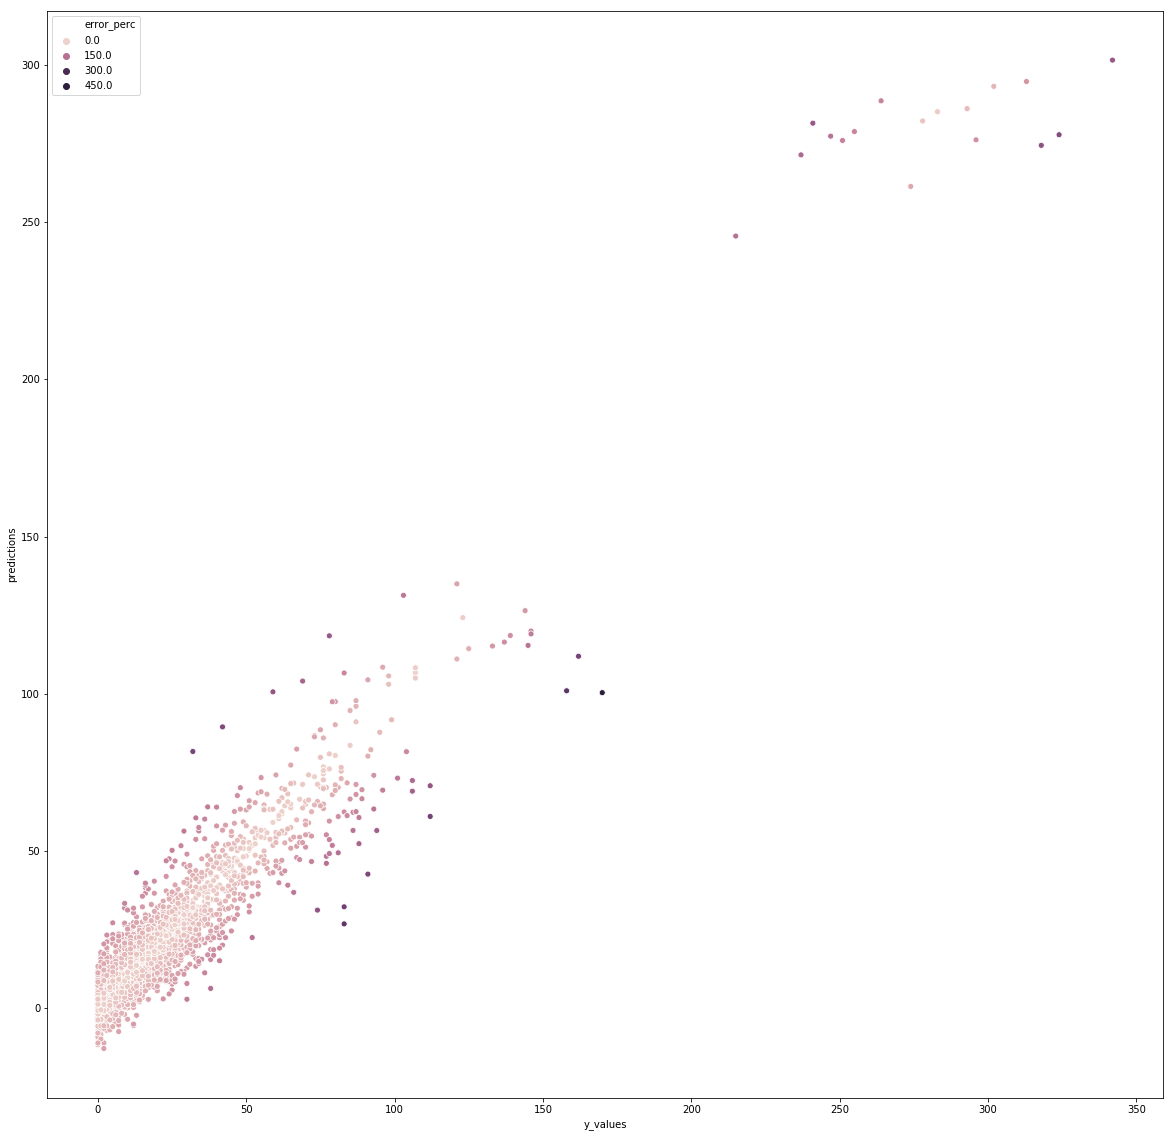

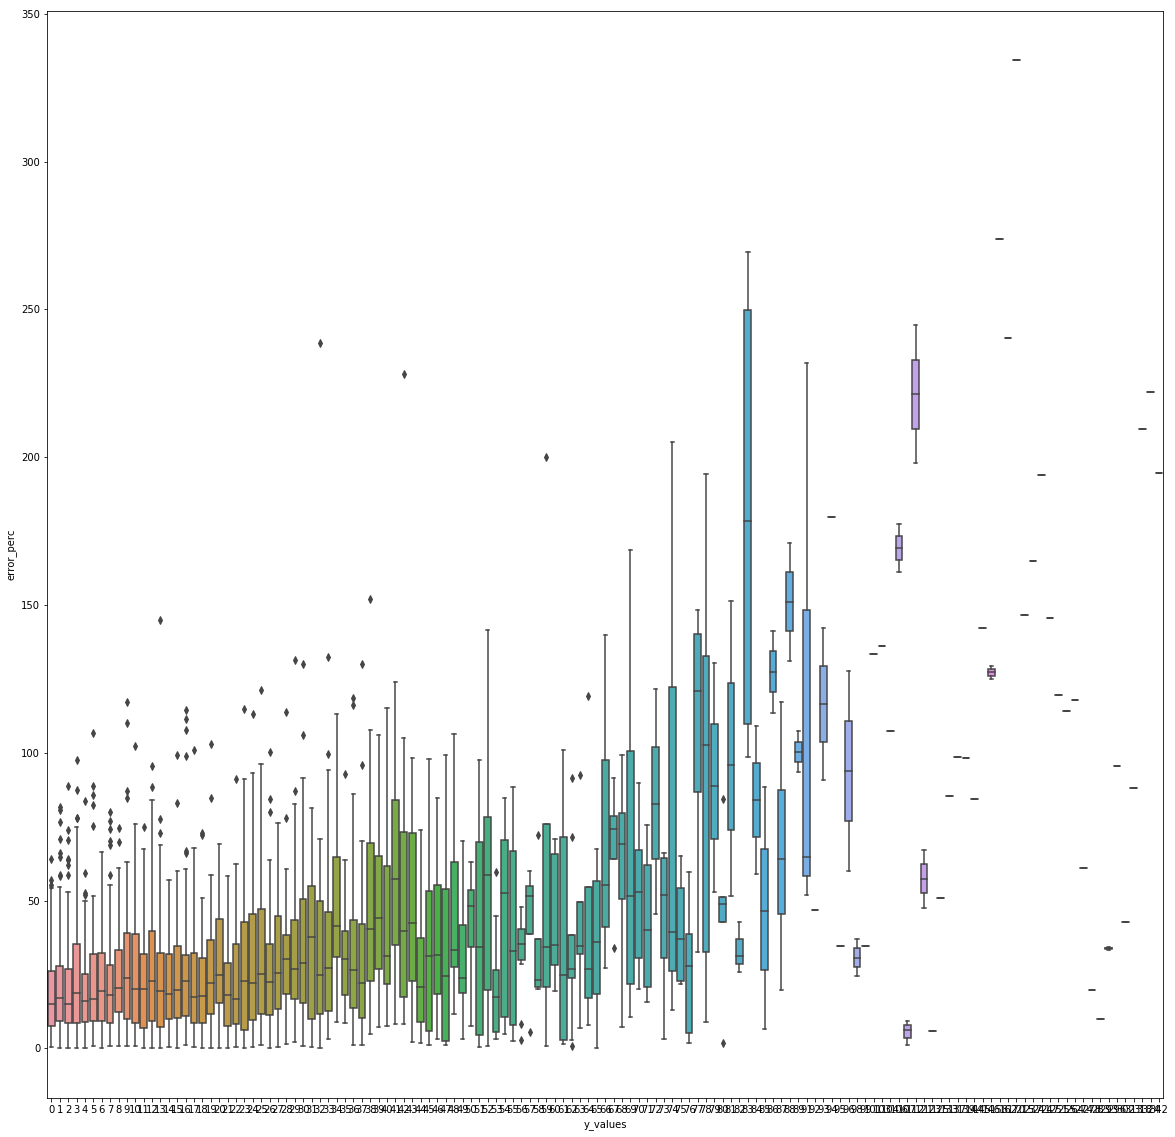

In [29]:
y_mean = df_save['y_values'].mean()
df_save['error_perc'] = abs(df_save['error'] / y_mean) * 100

plt.figure(figsize=(20, 20))
plt.xlabel('sample value')
plt.ylabel('prediction')
sns.scatterplot('y_values', 'predictions', hue='error_perc', data=df_save)
plt.show()

plt.figure(figsize=(20, 20))
sns.boxplot('y_values', 'error_perc', data=df_save)
plt.show()